In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import io
import math

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy

In [2]:
from utils import *
from data import *
from models import *
from train import *

In [3]:
%run data.py
%run utils.py
%run models.py
%run train.py

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Import

In [5]:
data_mit = import_mit_data()

In [6]:
beats = []
freq = 360

for i,patient in tqdm(enumerate(data_mit), total=len(data_mit)):
    for waveform, label in patient:
        rpeaks = wfdb.processing.xqrs_detect(waveform, fs=freq, verbose=False)

        for peak in rpeaks:
            if peak >= freq/2 and peak < len(waveform) - freq/2:
                partial_wave = waveform[peak-freq//2:peak+freq//2]
                partial_wave,_ = pywt.dwt(partial_wave, 'db6')
                partial_wave,_ = pywt.dwt(partial_wave, 'db6')
                beats.append((partial_wave, label, i)) 

100%|██████████| 48/48 [01:08<00:00,  1.42s/it]


In [7]:
beats[1000]

(array([-0.48653093, -0.52550738, -0.54090974, -0.49977151, -0.49303832,
        -0.49508027, -0.54647274, -0.52083588, -0.48870489, -0.49649643,
        -0.50309328, -0.48417202, -0.49393639, -0.48350579, -0.50730182,
        -0.53478639, -0.53133982, -0.52555819, -0.52737808, -0.52930386,
        -0.53796072, -0.55645202, -0.56148229, -0.58584673, -0.56586105,
        -0.55258514, -0.55736089, -0.53886046, -0.53682786, -0.56014755,
        -0.5556316 , -0.51642019, -0.43759544, -0.38100736, -0.34384513,
        -0.32122671, -0.35634075, -0.35353737, -0.35004944, -0.2714135 ,
        -0.3643947 , -0.48657   , -0.57553652, -0.57446683, -0.59970587,
        -0.58421751, -0.58892769, -0.59025968, -0.75057348, -1.00088145,
        -0.47500557,  1.68062488,  1.76246428, -0.49532649, -0.66768876,
        -0.66264251, -0.69803416, -0.68821537, -0.69175046, -0.70746479,
        -0.70775166, -0.70824397, -0.73308082, -0.72430196, -0.70585589,
        -0.72938336, -0.72802546, -0.72281864, -0.7

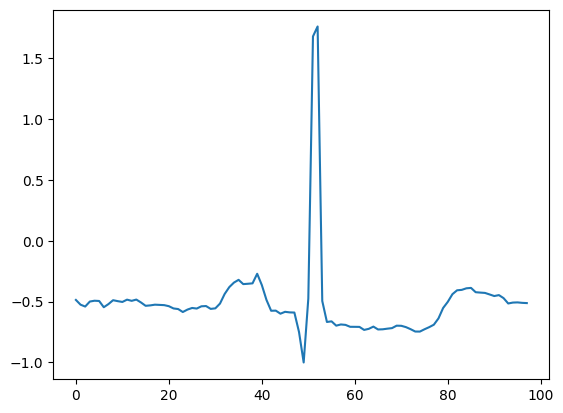

In [8]:
def plotbeat(x):
    if type(x) is tuple:
        plt.plot(x[0])
    else:
        plt.plot(x)

plotbeat(beats[1000])

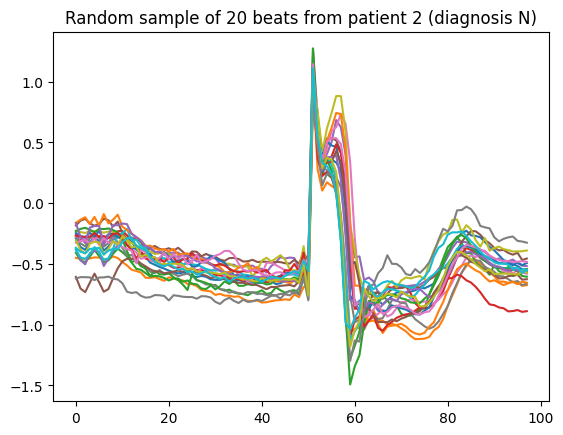

In [9]:
def plot_patient_beat_sample(patient, k):

    patient_beats = [x for x in beats if x[2] == patient]
    patient_beats = random.sample(patient_beats, k)

    for beat in patient_beats:
        plotbeat(beat)

    plt.title(f'Random sample of {k} beats from patient {patient} (diagnosis {beat[1]})')

plot_patient_beat_sample(2, 20)  

# Dataset

In [10]:
labels = list(set([x[1] for x in beats]))
label_map = {label:i for i,label in enumerate(labels)}

In [11]:
class BeatDataset(Dataset):
    def __init__(self, data, device, label_map, specify_patient=None):
        self.data = []

        for waveform, label, patient in tqdm(data):
            if specify_patient:
                if patient != specify_patient:
                    continue
                

            ## Z-score Normalisation
            waveform = (waveform - waveform.mean()) / waveform.std()

            self.data.append((
                torch.tensor(waveform, device=device, dtype=torch.float32),
                torch.tensor(label_map[label], device=device),
                patient
            ))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        waveform, label, patient = self.data[idx]

        return waveform, label
    
# beat_dataset = BeatDataset(random.sample(beats, 10), device, label_map)
beat_dataset = BeatDataset(beats, device, label_map)
beat_dataloader = DataLoader(beat_dataset, batch_size=128, shuffle=True)

100%|██████████| 76851/76851 [00:19<00:00, 3893.02it/s]


In [12]:
class Encoder(nn.Module):
    def __init__(self, lstm_count=32):
        super().__init__()

        self.lstm1 = nn.LSTM(input_size=1, hidden_size=lstm_count, batch_first=True)
        self.dropout = nn.Dropout(0.05)
        self.lstm2 = nn.LSTM(input_size=lstm_count, hidden_size=lstm_count, batch_first=True)

        self.fc_encoding_1 = nn.Linear(lstm_count*2, lstm_count*2)
        self.fc_encoding_2 = nn.Linear(lstm_count*2, lstm_count*2)
        self.fc_encoding_3 = nn.Linear(lstm_count*2, lstm_count)

    def forward(self, x):
        x = x.reshape((x.shape[0], x.shape[1], 1))
        x, _ = self.lstm1(x)
        x = self.dropout(x)
        _, hidden = self.lstm2(x)

        x = torch.cat(hidden, axis=2)
        x = x.squeeze(0)

        x = self.fc_encoding_1(x)
        x = F.sigmoid(x)
        x = self.fc_encoding_2(x)
        x = F.sigmoid(x)
        x = self.fc_encoding_3(x)
        x = F.sigmoid(x)

        return x
    
class Decoder(nn.Module):
    def __init__(self, seq_len=98, lstm_count=32):
        super().__init__()

        self.seq_len = seq_len
        self.lstm_count = lstm_count
        
        self.lstm1 = nn.LSTM(input_size=lstm_count, hidden_size=lstm_count, batch_first=True)
        self.dropout = nn.Dropout(0.05)
        self.lstm2 = nn.LSTM(input_size=lstm_count, hidden_size=lstm_count, batch_first=True)
        self.output_layer = nn.Linear(lstm_count, 1)

        self.fc_decoding_1 = nn.Linear(lstm_count, lstm_count*2)
        self.fc_decoding_2 = nn.Linear(lstm_count*2, lstm_count*2)
        self.fc_decoding_3 = nn.Linear(lstm_count*2, lstm_count*2)

    def forward(self, x):
        x = self.fc_decoding_1(x)
        x = F.sigmoid(x)
        x = self.fc_decoding_2(x)
        x = F.sigmoid(x)
        x = self.fc_decoding_3(x)

        x = x.unsqueeze(0)

        x = [x[:,:,:self.lstm_count].contiguous(),x[:,:,self.lstm_count:].contiguous()]

        x,_ = self.lstm1(torch.zeros([x[0].shape[1], self.seq_len, x[0].shape[2]], device=x[0].device), x)
        x = self.dropout(x)
        x,_ = self.lstm2(x)
        x = self.output_layer(x)

        return x.squeeze(2)

class AEModel(nn.Module):
    def __init__(self, lstm_count=32):
        super().__init__()

        self.encoder = Encoder(lstm_count=lstm_count)
        self.decoder = Decoder(lstm_count=lstm_count)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = AEModel(lstm_count=16).to(device)
model_path = 'autoencoder16_squeeze.pt'
model.load_state_dict(torch.load(model_path), strict=False)

<All keys matched successfully>

In [13]:
# # Freeze all parameters in the model
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the parameters in encoder.fc_encoding
# for param in model.encoder.fc_encoding_1.parameters():
#     param.requires_grad = True
# for param in model.encoder.fc_encoding_2.parameters():
#     param.requires_grad = True
# for param in model.encoder.fc_encoding_3.parameters():
#     param.requires_grad = True

# # Unfreeze the parameters in decoder.fc_decoding
# for param in model.decoder.fc_decoding_1.parameters():
#     param.requires_grad = True
# for param in model.decoder.fc_decoding_2.parameters():
#     param.requires_grad = True
# for param in model.decoder.fc_decoding_3.parameters():
#     param.requires_grad = True

In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

losses = []

In [15]:
# model_path = 'autoencoder16_squeeze2.pt'
# for epoch in range(10000):
#     model.train()

#     for i,batch in enumerate(beat_dataloader, 0):

#         optimizer.zero_grad()

#         seq, label = batch

#         seq_pred = model.forward(seq)

#         loss = criterion(seq, seq_pred)
#         loss.backward()
#         nn.utils.clip_grad_norm_(model.parameters(), max_norm=3.)
#         optimizer.step()

#     if epoch % 10 == 0:
#         model.eval()

#         totalloss = 0.

#         with torch.no_grad():
#             for i,batch in enumerate(beat_dataloader, 0):
#                 seq, label = batch

#                 seq_pred = model.forward(seq)

#                 loss = criterion(seq, seq_pred)

#                 totalloss += loss.item()

#         print(f'epoch {epoch}, loss {totalloss}')
#         losses.append(totalloss)

#     if epoch % 100 == 0:
#         torch.save(model.state_dict(), model_path)

In [16]:
# torch.save(model.state_dict(), model_path)

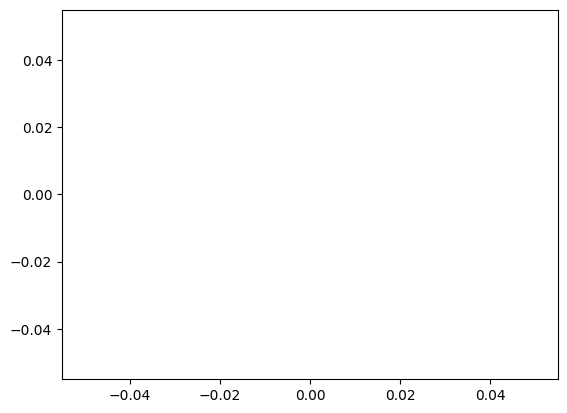

In [17]:
# plt.plot([np.log(x) for x in losses])
plt.plot(losses)

Text(0.5, 1.0, 'Autoencoder replicated heartbeat')

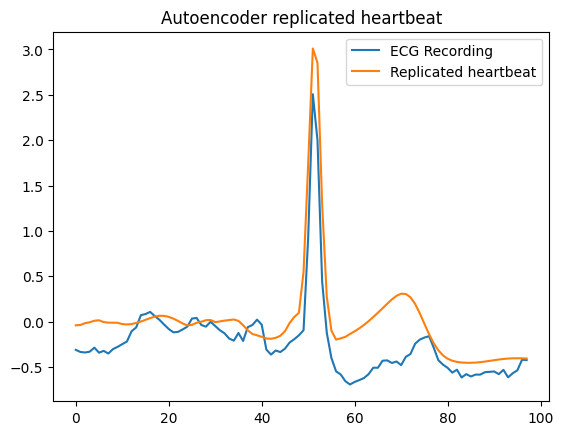

In [18]:
# i = 12425
i=9915
# i = 2

seq, label, _ = beats[i]
seq = torch.tensor(seq, dtype=torch.float32, device=device)
seq = seq.reshape((1,98))
model.eval()
seq_pred = model.forward(seq)

plt.plot(seq.detach().cpu().numpy().reshape(-1))
plt.plot(seq_pred.detach().cpu().numpy().reshape(-1))

plt.legend(['ECG Recording', 'Replicated heartbeat'])

plt.title('Autoencoder replicated heartbeat')


# Distribution Difference

In [19]:
users = [{key:[] for key in label_map.keys()} for i in range(48)]

for beat in beats:
    users[beat[2]][beat[1]].append(beat[0])

In [20]:
def encode(beats):
    values = np.stack(beats, axis=1).reshape((-1, 98))
    seq = torch.tensor(values, dtype=torch.float32, device=device)
    model.eval()
    with torch.no_grad():
        encoded = model.encoder.forward(seq)
    # encoded = torch.concat(encoded, dim=2).squeeze(0)
    return encoded.detach().cpu().numpy()

In [21]:
category = 'N'

groups = []
for patient in users:
    if len(patient[category]) > 1000:
        groups.append(patient[category])

len(groups)

31

## Heuristics

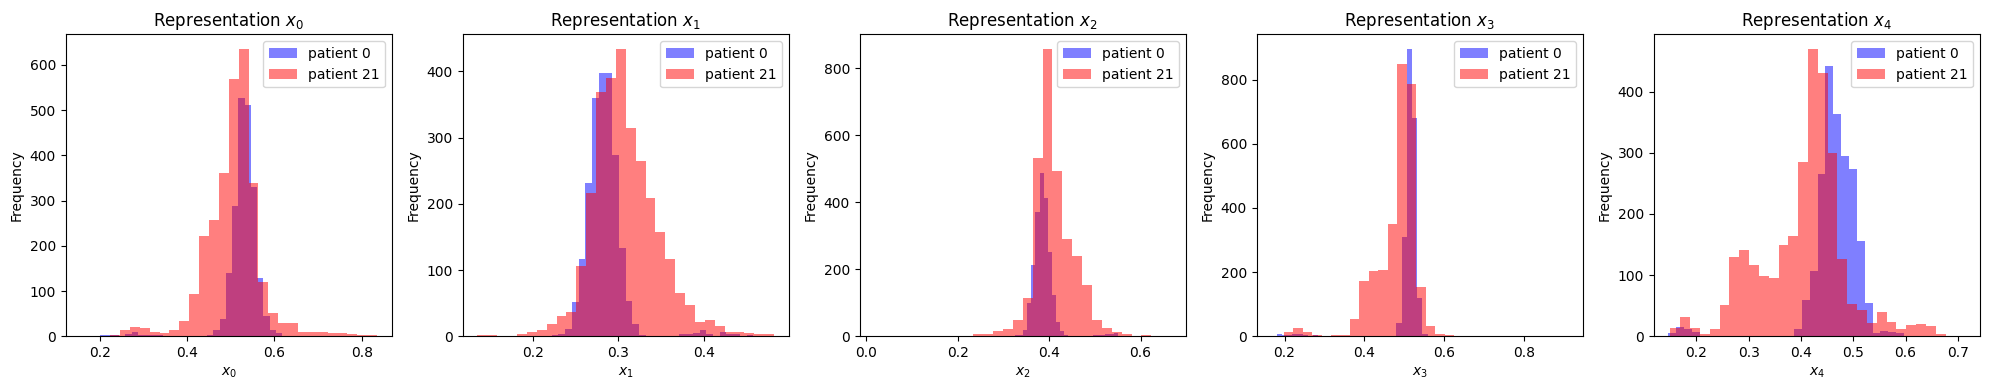

In [22]:
def plot_hist_comparison(groups, a, b, i):
    A = encode(groups[a])
    B = encode(groups[b])

    plt.hist(A[:,i], bins=30, alpha=0.5, label='Dataset 1', color='blue')  # Dataset 1 in blue
    plt.hist(B[:,i], bins=30, alpha=0.5, label='Dataset 2', color='red')   # Dataset 2 in red

    plt.xlabel(f'$x_{{{i}}}$')
    plt.ylabel('Frequency')
    plt.title(f'Representation $x_{i}$ in patient {a} vs {b}')
    plt.legend([f'patient {a}', f'patient {b}'])

    plt.show()

def plot_hist_comparison_side_by_side(groups, a, b):
    fig, axs = plt.subplots(1, 5, figsize=(20, 4))
    
    for i in range(5):
        A = encode(groups[a])
        B = encode(groups[b])
        
        axs[i].hist(A[:, i], bins=30, alpha=0.5, label=f'patient {a}', color='blue')
        axs[i].hist(B[:, i], bins=30, alpha=0.5, label=f'patient {b}', color='red')
        
        axs[i].set_xlabel(f'$x_{{{i}}}$')
        axs[i].set_ylabel('Frequency')
        axs[i].set_title(f'Representation $x_{i}$')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

plot_hist_comparison_side_by_side(groups, 0, 21)
# plot_hist_comparison(groups, 0, 21, 5)
# plot_hist_comparison(groups, 2,3, 4)

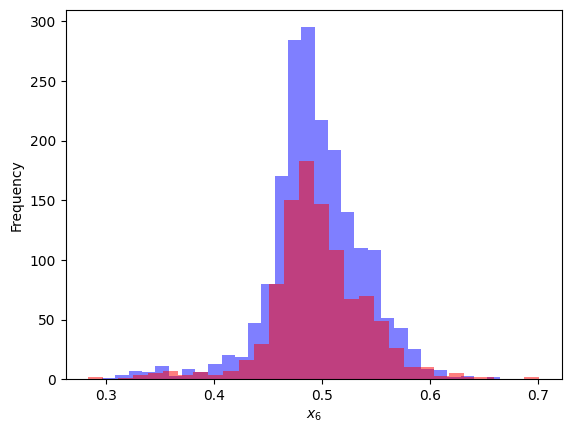

In [23]:
i = 6

A = encode(groups[21][1000:])
B = encode(groups[21][:1000])

plt.hist(A[:,i], bins=30, alpha=0.5, label='Dataset 1', color='blue')  # Dataset 1 in blue
plt.hist(B[:,i], bins=30, alpha=0.5, label='Dataset 2', color='red')   # Dataset 2 in red

plt.xlabel(f'$x_{{{i}}}$')
plt.ylabel('Frequency')
# plt.title(f'Representation $x_{i}$ in patient {a} vs {b}')
# plt.legend([f'patient {a}', f'patient {b}'])

plt.show()

0.01174043392531054


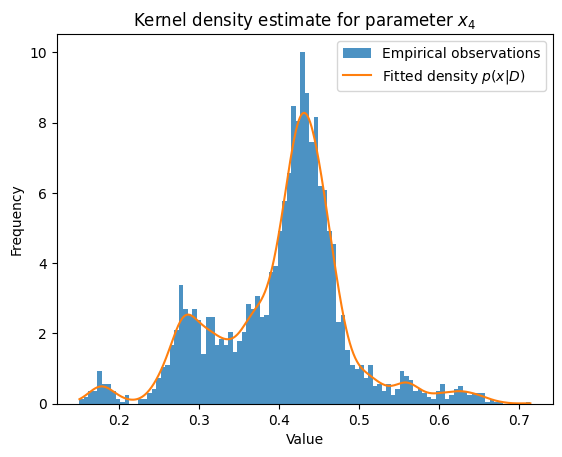

In [24]:
def estimate_bandwidth(data):
    h_d = []

    for i in range(data.shape[1]):
        h_d.append(math.pow(4/(3*data.shape[0]), 0.2) * data[:,i].std())

    return np.prod(h_d) ** (1/len(h_d))

def plot_kde(beats, i):
    x = encode(beats)

    x_d = np.linspace(min(x[:,i]), max(x[:,i]), 1000)

    print(estimate_bandwidth(x))
    kde_D1 = KernelDensity(bandwidth=estimate_bandwidth(x), kernel='gaussian')
    kde_D1.fit(x[:,i].reshape(-1, 1))  # Reshape data for fitting
    log_density = kde_D1.score_samples(x_d.reshape(-1, 1))


    plt.hist(x[:,i], bins=100, density=True, alpha=0.8, label='Histogram')
    plt.plot(x_d, np.exp(log_density), label='KDE')

    plt.title(f'Kernel density estimate for parameter $x_{{{i}}}$')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

    plt.legend(['Empirical observations', 'Fitted density $p(x | D)$'])

    plt.show()

plot_kde(groups[21], 4)

## Relative Entropy

In [39]:
## Relative entropy calculation

def relative_entropy(encode_1, encode_2):
    kde_D1 = KernelDensity(bandwidth=estimate_bandwidth(encode_1), kernel='gaussian').fit(encode_1)
    kde_D2 = KernelDensity(bandwidth=estimate_bandwidth(encode_2), kernel='gaussian').fit(encode_2)

    X = np.vstack([encode_1, encode_2])
    # X = np.vstack([encode_1[:min(len(encode_1), len(encode_2))], encode_2[:min(len(encode_1), len(encode_2))]])

    log_prob_D1 = kde_D1.score_samples(X)
    log_prob_D2 = kde_D2.score_samples(X)

    epsilon = 1e-10
    prob_D1 = np.exp(log_prob_D1) + epsilon
    prob_D2 = np.exp(log_prob_D2) + epsilon

    # Calculate the KL divergence
    kl_divergence = entropy(prob_D1, prob_D2) + entropy(prob_D2, prob_D1)
    # kl_divergence = jensenshannon(prob_D1, prob_D2)

    # print(entropy(prob_D1, prob_D2), entropy(prob_D2, prob_D1))

    return kl_divergence

def encode_beats(beats):
    return 

# group_1 = users[30]['N'][:1000]
# group_2 = users[30]['N'][1000:]
# group_2 = users[14]['N'][:1000]
# group_2 = users[20]['R'][:1000]


for i in range(16):
    print(relative_entropy(encode(groups[21][:1000])[:,i:i+1], encode(groups[21][1000:])[:,i:i+1]))

    
print(relative_entropy(encode(groups[21][:1000]), encode(groups[21][1000:])))

0.0023481861294819394
0.005474476038882873
0.001914110460573546
0.001796403049400705
0.004482867479174478
0.00477555102645664
0.0011313044342222871
0.0032822793594781746
0.006412401362607453
0.007553282315818551
0.006625018351703719
0.007046254324153985
0.0071892994313940235
0.005516370212309081
0.006498746137416734
0.002053902854125051
23.821142714429605


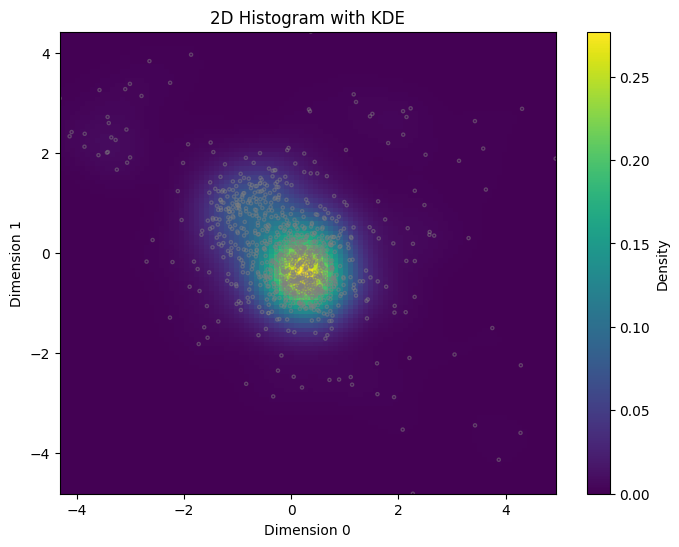

In [29]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

def plot_2d_density(beats, i=0, j=1):
    # Assuming beats is your data array of shape (n_samples, n_features)

    encoded = encode(beats)
    
    # Select two dimensions
    data_2d = encoded[:, [i, j]]
    
    # Scale data for better KDE performance
    scaler = StandardScaler()
    data_2d_scaled = scaler.fit_transform(data_2d)
    
    # Fit KDE
    params = {'bandwidth': np.logspace(-1, 1, 20)}
    grid = GridSearchCV(KernelDensity(kernel='gaussian'), params)
    grid.fit(data_2d_scaled)
    
    kde = grid.best_estimator_
    
    # Create grid to evaluate KDE
    x = np.linspace(data_2d_scaled[:, 0].min(), data_2d_scaled[:, 0].max(), 100)
    y = np.linspace(data_2d_scaled[:, 1].min(), data_2d_scaled[:, 1].max(), 100)
    X, Y = np.meshgrid(x, y)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    Z = np.exp(kde.score_samples(xy)).reshape(X.shape)
    
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(data_2d_scaled[:, 0], data_2d_scaled[:, 1], s=5, facecolor='none', edgecolor='grey', alpha=0.5)
    plt.imshow(Z, aspect='auto', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], cmap='viridis')
    plt.colorbar(label='Density')
    plt.xlabel(f'Dimension {i}')
    plt.ylabel(f'Dimension {j}')
    plt.title('2D Histogram with KDE')
    plt.show()

# group_1 = users[30]['N'][:1000]
# group_2 = users[30]['N'][1000:]
# group_2 = users[14]['N'][:1000]
# group_2 = users[20]['R'][:1000]

plot_2d_density(groups[21][:1000])    

# print(relative_entropy(groups[21][:1000], groups[21][1000:]))

In [40]:
def calculate_divergences_category(category):
    groups = []
    for patient in users:
        if len(patient[category]) > 1000:
            groups.append(encode(patient[category]))

    matrix = np.zeros((len(groups), len(groups)))

    avg_intergroup = 0
    for i,patient in enumerate(groups):
        entropy = relative_entropy(patient[:patient.shape[0]//2,:], patient[patient.shape[0]//2:,:])
        avg_intergroup += entropy
        matrix[i][i] = entropy

    avg_intergroup /= len(groups)

    avg_betweengroup = 0
    count = 0

    for i in tqdm(range(len(groups))):
        for j in range(i+1, len(groups)):
            entropy = relative_entropy(groups[i], groups[j])
            avg_betweengroup += entropy
            count += 1

            matrix[i,j] = entropy
            matrix[j,i] = entropy

    avg_betweengroup /= count
    
    return avg_intergroup, avg_betweengroup, matrix

def calculate_divergences_category_1d(category):
    groups = []
    for patient in users:
        if len(patient[category]) > 100:
            groups.append(encode(patient[category]))

    matrix = np.zeros((len(groups), len(groups)))

    avg_intergroup = 0
    for i,patient in enumerate(groups):
        for j in range(16):
            entropy = relative_entropy(patient[:patient.shape[0]//2,j:j+1], patient[patient.shape[0]//2:,j:j+1])
            avg_intergroup += entropy
            matrix[i][i] = entropy

    avg_intergroup /= len(groups) * 16

    avg_betweengroup = 0
    count = 0

    for i in tqdm(range(len(groups))):
        for j in range(i+1, len(groups)):
            for k in range(16):
                entropy = relative_entropy(groups[i][:,k:k+1], groups[j][:,k:k+1])
                avg_betweengroup += entropy
                count += 1

                matrix[i,j] = entropy
                matrix[j,i] = entropy

    avg_betweengroup /= count
    
    return avg_intergroup, avg_betweengroup, matrix

calculate_divergences_category_1d('P')

100%|██████████| 2/2 [00:00<00:00,  4.26it/s]


(0.033368887420241335,
 0.13692430454531737,
 array([[0.01235352, 0.13030181],
        [0.13030181, 0.01733101]]))

In [42]:
calculate_divergences_category_1d('N')

100%|██████████| 40/40 [1:12:53<00:00, 109.33s/it]


(0.13579869023694696,
 1.7037236257362296,
 array([[0.27620118, 0.29020969, 0.23199217, ..., 0.35661899, 0.67611396,
         0.68446545],
        [0.29020969, 0.02002235, 0.2397445 , ..., 0.31282444, 0.12290332,
         0.16154633],
        [0.23199217, 0.2397445 , 0.21362342, ..., 0.13832147, 0.45437482,
         0.15463726],
        ...,
        [0.35661899, 0.31282444, 0.13832147, ..., 0.09643036, 0.36379585,
         0.03601201],
        [0.67611396, 0.12290332, 0.45437482, ..., 0.36379585, 0.01648375,
         0.12977914],
        [0.68446545, 0.16154633, 0.15463726, ..., 0.03601201, 0.12977914,
         0.00867691]]))

In [43]:
calculate_divergences_category_1d('R')

100%|██████████| 4/4 [00:28<00:00,  7.22s/it]


(0.2020502600710216,
 1.9765413713057365,
 array([[0.0285108 , 0.02586473, 3.74527678, 4.22715576],
        [0.02586473, 0.01365367, 3.81014702, 4.22237247],
        [3.74527678, 3.81014702, 0.03954263, 0.04041716],
        [4.22715576, 4.22237247, 0.04041716, 0.20314992]]))

In [44]:
calculate_divergences_category_1d('L')

100%|██████████| 4/4 [00:40<00:00, 10.06s/it]


(0.23614307566797135,
 0.1496719175061209,
 array([[0.17219793, 0.12598984, 0.1563201 , 0.07766852],
        [0.12598984, 0.02508521, 0.01813448, 0.05216148],
        [0.1563201 , 0.01813448, 0.16168875, 0.11847318],
        [0.07766852, 0.05216148, 0.11847318, 0.18482884]]))

In [31]:
len(groups)

31

In [ ]:
y = encode(groups[0]).detach().cpu().numpy()
x = encode(groups[1]).detach().cpu().numpy()